<h1>개인 구글 드라이브와 colab 연동</h1>

In [1]:
from google.colab import drive
drive.mount("/gdrive", force_remount=True)

Mounted at /gdrive


In [2]:
!pip install pytorch-crf

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


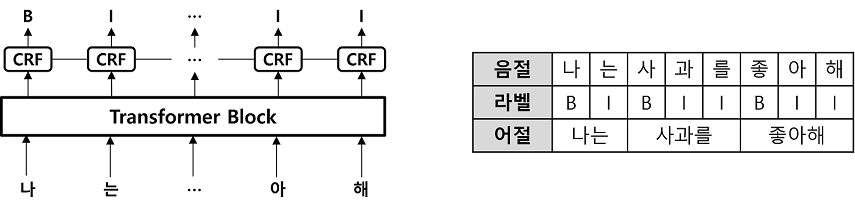

In [3]:
from IPython.display import Image
Image("/gdrive/My Drive/colab/TRANSFORMER_CRF/TRANSFORMER_CRF.png")

<h1>TRANSFORMER_CRF 모델을 이용한 자동 띄어쓰기</h1>

In [9]:
import torch
import torch.nn as nn
from torchcrf import CRF


class TRANSFORMER_CRF(nn.Module):

    def __init__(self, config):
        super(TRANSFORMER_CRF, self).__init__()

        # 전체 음절 개수
        self.eumjeol_vocab_size = config["eumjeol_vocab_size"]

        # 음절 임베딩 사이즈
        self.embedding_size = config["embedding_size"]

        # 최대 길이 (음절 기준)
        self.max_length = config["max_length"]

        # Transformer 히든 사이즈
        self.hidden_size = config["hidden_size"]

        # Transformer head 개수
        self.num_heads = config["num_heads"]
        
        # Transformer layer 개수
        self.num_layers = config["num_layers"]

        # 분류할 태그의 개수
        self.number_of_tags = config["number_of_tags"]

        self.dropout = nn.Dropout(config["dropout"])

        # 입력 데이터에 있는 각 음절 index를 대응하는 임베딩 벡터로 치환해주기 위한 임베딩 객체
        self.embedding = nn.Embedding(num_embeddings=self.eumjeol_vocab_size,
                                      embedding_dim=self.embedding_size,
                                      padding_idx=0)
        # 입력 데이터의 각 음절들의 위치 정보를 반영해주기 위한 임베딩 객체
        self.position_embedding = nn.Embedding(num_embeddings=self.max_length,
                                               embedding_dim=self.embedding_size)
        self.embedding_layer_norm = nn.LayerNorm(normalized_shape=self.embedding_size)

        # Transformer encoder layer
        self.encoder = nn.TransformerEncoder(encoder_layer=nn.TransformerEncoderLayer(d_model=self.hidden_size,
                                                                                      nhead=self.num_heads,
                                                                                      dim_feedforward=self.hidden_size,
                                                                                      batch_first=True),
                                             num_layers=self.num_layers)

        # Transformer layer의 출력 벡터 크기를 number_of_tags로 변환하기 위한 비선형 함수
        self.hidden2num_tag = nn.Sequential(nn.Linear(in_features=self.hidden_size, out_features=self.hidden_size),
                                            nn.ReLU(),
                                            nn.Linear(in_features=self.hidden_size, out_features=self.number_of_tags))
        
        # CRF layer
        self.crf = CRF(num_tags=self.number_of_tags, batch_first=True)

    def forward(self, inputs, positions, labels=None):
        # inputs : (batch_size, max_length)
        # eumjeol_inputs : (batch_size, max_length, embedding_size)
        eumjeol_inputs = self.embedding(inputs) + self.position_embedding(positions)
        eumjeol_inputs = self.embedding_layer_norm(eumjeol_inputs)
        eumjeol_inputs = self.dropout(eumjeol_inputs)

        # encoder_output : (batch_size, max_length, hidden_size)
        # src_key_padding_mask를 통해 padding 부분은 반영하지 않도록함
        encoder_output = self.encoder(src=eumjeol_inputs, src_key_padding_mask=(inputs == 0))

        # (batch_size, max_length, hidden_size) -> (batch_size, max_length, number_of_tags)
        hidden_outputs = self.hidden2num_tag(encoder_output)

        if(labels is not None):
            log_likelihood = self.crf(emissions=hidden_outputs,
                                      tags=labels,
                                      mask=(inputs != 0),
                                      reduction="mean")

            loss = log_likelihood * -1.0

            return loss
        else:
            output = self.crf.decode(emissions=hidden_outputs, mask=(inputs != 0))
            return output

<h1>데이터 읽고 전처리 하기</h1>

<pre>
<b>1. read_data(file_path)</b>
  "train_datas.txt", "test_datas.txt" 파일을 읽기 위한 함수
  
  데이터 예시)
    나 의 사 랑 한 글 날 \t B I B I B I I
  
  read_file(file_path)
  args
    file_path : 읽고자 하는 데이터의 경로
  return
    datas : 음절 sequence, 각 음절에 대응하는 라벨 sequence를 담고 있는 리스트
    
    출력 예시)
      datas = [
        (["나", "의", "사", "랑", "한", "글", "날"], ["B", "I", "B", "I", "B", "I", "I"])

        (...),
        
        ]
      
<b>2. read_vocab_data(vocab_data_path)</b>
  "eumjeol_vocab.txt", "label_vocab.txt" 파일을 읽고 음절과 라벨을 indexing하기 위한 딕셔너리를 생성
   
  read_vocab_data(vocab_data_path)
  args
    vocab_data_path : 어휘 파일 경로
  return  
    term2idx : 음절 또는 라벨을 대응하는 index로 치환하기 위한 딕셔너리
    idx2term : index를 대응하는 음절 또는 라벨로 치환하기 위한 딕셔너리

    
<b>3. convert_data2feature(datas, max_length, eumjeol2idx, label2idx)</b>
  입력 데이터를 고정된 길이로 변환 후 indexing
  Tensor로 변환
   
  convert_data2feature(datas, max_length, eumjeol2idx, label2idx)
  args
    datas : 음절 sequence, 각 음절에 대응하는 라벨 sequence를 담고 있는 리스트
    max_length : 입력의 최대 길이
    eumjeol2idx : 음절을 대응하는 index로 치환하기 위한 딕셔너리
    label2idx : 라벨을 대응하는 index로 치환하기 위한 딕셔너리
  return
    eumjeol_features : index로 치환된 음절 sequence
    position_features : 각 음절의 위치 정보를 담고 있는 위치 sequence
    label_features : index로 치환된 라벨 sequence
    
  전처리 예시)
    datas = [(["나", "의", "사", "랑", "한", "글", "날"], ["B", "I", "B", "I", "B", "I", "I"]),

    (...),
    
    ]
    
    사전 설정한 문장의 최대 길이를 10이라고 가정
    
    ["나", "의", "사", "랑", "한", "글", "날"] -> ["나", "의", "사", "랑", "한", "글", "날", "<PAD>", "<PAD>", "<PAD>"]
    ["나", "의", "사", "랑", "한", "글", "날", "<PAD>", "<PAD>", "<PAD>"] -> [ 23, 2, 55, 65, 96, 12, 4, 0, 0, 0 ]
    
    [ "B", "I", "B", "I", "B", "I", "I" ] -> [ "B", "I", "B", "I", "B", "I", "I", "<PAD>", "<PAD>", "<PAD>" ]
    [ "B", "I", "B", "I", "B", "I", "I", "<PAD>", "<PAD>", "<PAD>" ] -> [ 1, 2, 1, 2, 1, 2, 2, 0, 0, 0 ]    

    eumjeol_features : Tensor([ 23, 2, 55, 65, 96, 12, 4, 0, 0, 0 ], [...], ...)
    position_features : Tensor([0, 1, 2, 3, 4, 5, ..., ])
    label_features : Tensor([ 1, 2, 1, 2, 1, 2, 2, 0, 0, 0 ], [...], ...)
 </pre>


In [10]:
import torch
import numpy as np
from tqdm import tqdm

# 학습 or 평가 데이터를 읽어 리스트에 저장
def read_data(file_path):
    with open(file_path, "r", encoding="utf8") as inFile:
        lines = inFile.readlines()

    datas = []
    for line in tqdm(lines, desc="read_data"):

        # 입력 문장을 \t으로 분리
        pieces = line.strip().split("\t")

        # 입력 문자열을 음절 단위로 분리
        eumjeol_sequence, label_sequence = pieces[0].split(), pieces[1].split()

        # 음절 sequence의 길이와 라벨 sequence의 길이가 동일한지 체크
        assert len(eumjeol_sequence) == len(label_sequence)

        datas.append((eumjeol_sequence, label_sequence))

    return datas

# 데이터를 읽고 딕셔너리 생성
def read_vocab_data(vocab_data_path):
    term2idx, idx2term = {"<PAD>":0}, {0:"<PAD>"}

    with open(vocab_data_path, "r", encoding="utf8") as inFile:
        lines = inFile.readlines()

    for line in lines:
        term = line.strip()
        term2idx[term] = len(term2idx)
        idx2term[term2idx[term]] = term

    return term2idx, idx2term

# 입력 데이터 전처리
def convert_data2feature(datas, max_length, eumjeol2idx, label2idx):
  # 음절 데이터, 음절들의 위치 정보, 라벨 데이터를 담을 리스트
    eumjeol_features, position_features, label_features = [], [], []

    for eumjeol_sequence, label_sequence in tqdm(datas, desc="convert_data2feature"):

        # 사전 설정한 max_length의 길이를 갖는 numpy array 생성
        eumjeol_feature = np.zeros(shape=(max_length), dtype=int)
        position_feature = np.zeros(shape=(max_length), dtype=int)
        label_feature = np.zeros(shape=(max_length), dtype=int)

        # 음절 sequence와 라벨 sequence의 각 값들을 index로 치환하고 위에서 생성한 numpy array에 저장
        # 각 음절의 위치 정보를 위에서 생성한 numpy array에 저장
        for index in range(len(eumjeol_sequence[:max_length])):
            eumjeol_feature[index] = eumjeol2idx[eumjeol_sequence[index]]
            position_feature[index] = index
            label_feature[index] = label2idx[label_sequence[index]]

        # 변환한 데이터를 각 리스트에 저장
        eumjeol_features.append(eumjeol_feature)
        position_features.append(position_feature)
        label_features.append(label_feature)

    # 변환한 데이터를 Tensor 객체에 담아 반환
    eumjeol_features = torch.tensor(np.array(eumjeol_features), dtype=torch.long)
    position_features = torch.tensor(np.array(position_features), dtype=torch.long)
    label_features = torch.tensor(np.array(label_features), dtype=torch.long)

    return eumjeol_features, position_features, label_features

<h1>TRANSFORMER_CRF 모델 학습</h1>

<pre>
<b>1. read_data(file_path) 함수를 사용하여 학습 및 평가 데이터 읽기</b>

<b>2. read_vocab_data(vocab_data_path) 함수를 사용하여 어휘 딕셔너리 생성</b>

<b>3. convert_data2feature(datas, max_length, eumjeol2idx, label2idx) 함수를 사용하여 데이터 전처리</b>

<b>4. TRANSFORMER_CRF 모델 선언</b>

<b>5. epoch를 돌때마다 평가 데이터를 이용하여 성능 측정 후 기존 성능보다 높은 경우에만 모델 파일 저장</b>
</pre>

In [11]:
import os
import numpy as np
from tqdm import tqdm
from sklearn.metrics import accuracy_score

import torch
from torch.utils.data import (DataLoader, TensorDataset, RandomSampler, SequentialSampler)
import torch.optim as optim


def train(config):
    # 학습 데이터 읽기
    train_datas = read_data(config["train_data_path"])
    
    # 평가 데이터 읽기
    test_datas = read_data(config["test_data_path"])

    # 어휘 딕셔너리 생성
    eumjeol2idx, idx2eumjeol = read_vocab_data(vocab_data_path=config["word_vocab_data_path"])
    # 라벨 딕셔너리 생성
    label2idx, idx2label = read_vocab_data(vocab_data_path=config["label_vocab_data_path"])

    # 입력 데이터 전처리
    train_eumjeol_features, train_position_features, train_label_features = convert_data2feature(train_datas, config["max_length"], eumjeol2idx, label2idx)
    test_eumjeol_features, test_position_features, test_label_features = convert_data2feature(test_datas, config["max_length"], eumjeol2idx, label2idx)

    # 학습 데이터를 batch 단위로 추출하기 위한 DataLoader 객체 생성
    train_features = TensorDataset(train_eumjeol_features, train_position_features, train_label_features)
    train_dataloader = DataLoader(train_features, sampler=RandomSampler(train_features), batch_size=config["batch_size"])

    # 평가 데이터를 batch 단위로 추출하기 위한 DataLoader 객체 생성
    test_features = TensorDataset(test_eumjeol_features, test_position_features, test_label_features)
    test_dataloader = DataLoader(test_features, sampler=SequentialSampler(test_features), batch_size=config["batch_size"])

    # TRANSFORMER_CRF 모델 객체 생성
    model = TRANSFORMER_CRF(config).cuda()

    # 모델 학습을 위한 optimizer
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # 모델의 최고 정확도를 저장하기 위한 변수
    max_accuracy = 0
    for epoch in range(config["epoch"]):
        model.train()

        losses = []
        for step, batch in enumerate(tqdm(train_dataloader, desc="epoch_{}_train".format(epoch+1))):
            batch = tuple(t.cuda() for t in batch)

            # 음절 데이터, 음절 위치 데이터, 라벨 데이터
            inputs, positions, labels = batch[0], batch[1], batch[2]

            # 역전파 단계를 실행하기 전에 변화도를 0으로 변경
            optimizer.zero_grad()

            # 모델 학습
            loss = model(inputs, positions, labels)

            # loss 값으로부터 모델 내부 각 매개변수에 대하여 gradient 계산
            loss.backward()

            # 모델 내부 각 매개변수 가중치 갱신
            optimizer.step()

            # batch 단위 loss 값 저장
            losses.append(loss.data.item())

        model.eval()

        # 모델의 출력 결과와 실제 정답값을 담을 리스트
        total_predicts, total_labels = [], []
        for step, batch in enumerate(tqdm(test_dataloader, desc="epoch_{}_test".format(epoch+1))):
            batch = tuple(t.cuda() for t in batch)
            # 음절 데이터, 음절 위치 데이터, 라벨 데이터
            inputs, positions, labels = batch[0], batch[1], batch[2]

            # 모델 평가
            with torch.no_grad():
                predicts = model(inputs, positions)

            # Tensor를 리스트로 변경
            labels = labels.cpu().detach().numpy().tolist()
            # padding 제거
            labels = [labels[index][:len(predicts[index])] for index in range(len(predicts))]

            # batch 단위 출력 결과와 정답을 리스트에 저장
            for index in range(len(predicts)):
                total_predicts += predicts[index]
                total_labels += labels[index]

        # 정확도 계산
        accuracy = accuracy_score(total_labels, total_predicts)

        # 현재의 정확도가 기존 정확도보다 높은 경우 모델 파일 저장
        if(max_accuracy < accuracy):
            max_accuracy = accuracy

            torch.save(model.state_dict(), os.path.join(output_dir, "epoch_{}.pt".format(epoch+1)))

        # epoch 별로 평균 loss 값과 정확도 출력
        print("Average loss : {},\tAccuracy : {}".format(np.mean(losses), accuracy))

<h1>TRANSFORMER_CRF 모델 평가</h1>

<pre>
<b>1. read_data(file_path) 함수를 사용하여 평가 데이터 읽기</b>

<b>2. read_vocab_data(vocab_data_path) 함수를 사용하여 어휘 딕셔너리 생성</b>

<b>3. convert_data2feature(datas, max_length, eumjeol2idx, label2idx) 함수를 사용하여 데이터 전처리</b>

<b>4. TRANSFORMER_CRF 모델 객체 선언</b>

<b>5. load_state_dict() 함수를 사용하여 학습한 모델 파일로부터 가중치를 불러옴</b>

<b>6. make_sentence(inputs, predicts, labels, idx2eumjeol, idx2label) 함수를 이용하여 정답과 모델 출력 비교</b>
  
  make_sentence(inputs, predicts, labels, idx2eumjeol, idx2label)
  args
    inputs : 음절 sequence
    predicts : 모델 출력 라벨 sequence
    labels : 정답 라벨 sequence
    idx2eumjeol : index를 대응하는 음절로 치환해주는 딕셔너리
    idx2label : index를 대응하는 라벨로 치환해주는 딕셔너리
  return
    정답 문장과 모델 출력 문장
  
  예시)
    inputs = ["나", "의", "사", "랑", "한", "글", "날"]
    predict = ["B", "B", "B", "I", "I", "I", "I"]
    correct = ["B", "I", "B", "I", "B", "I", "I"]
    
    정답 문장 : 나의 사랑 한글날
    모델 출력 문장 : 나 의 사랑한글날
</pre>

In [12]:
import os
import numpy as np
from tqdm import tqdm
from sklearn.metrics import accuracy_score

import torch
from torch.utils.data import (DataLoader, SequentialSampler, TensorDataset)


def test(config):
    # 평가 데이터 읽기
    test_datas = read_data(config["test_data_path"])

    # 어휘 딕셔너리 생성
    eumjeol2idx, idx2eumjeol = read_vocab_data(vocab_data_path=config["word_vocab_data_path"])

    # 라벨 딕셔너리 생성
    label2idx, idx2label = read_vocab_data(vocab_data_path=config["label_vocab_data_path"])

    # 입력 데이터 전처리
    test_eumjeol_features, test_position_features, test_label_features = convert_data2feature(test_datas, config["max_length"], eumjeol2idx, label2idx)

    # 평가 데이터를 batch 단위로 추출하기 위한 DataLoader 객체 생성
    test_features = TensorDataset(test_eumjeol_features, test_position_features, test_label_features)
    test_dataloader = DataLoader(test_features, sampler=SequentialSampler(test_features), batch_size=config["batch_size"])

    # TRANSFORMER_CRF 모델 객체 생성
    model = TRANSFORMER_CRF(config).cuda()
    # 사전학습한 모델 파일로부터 가중치 불러옴
    model.load_state_dict(torch.load(os.path.join(config["save_dir_path"], config["trained_model_name"])))

    model.eval()

    # 모델의 출력 결과와 실제 정답값을 담을 리스트
    total_predicts, total_labels = [], []
    for step, batch in enumerate(tqdm(test_dataloader, desc="test")):
        batch = tuple(t.cuda() for t in batch)
        # 음절 데이터, 음절 위치 데이터, 라벨 데이터
        inputs, positions, labels = batch[0], batch[1], batch[2]

        # 모델 평가
        with torch.no_grad():
            predicts = model(inputs, positions)

        # Tensor를 리스트로 변경
        inputs = inputs.cpu().detach().numpy().tolist()
        labels = labels.cpu().detach().numpy().tolist()

        # padding 제거
        inputs = [inputs[index][:len(predicts[index])] for index in range(len(predicts))]
        labels = [labels[index][:len(predicts[index])] for index in range(len(predicts))]

        # batch 단위 출력 결과와 정답을 리스트에 저장
        for index in range(len(predicts)):
            total_predicts += predicts[index]
            total_labels += labels[index]

        if(step == 0):
            for temp_index in range(10):
                # 정답과 모델 출력 비교
                predict_sentence, correct_sentence = make_sentence(inputs[temp_index], predicts[temp_index], labels[temp_index], idx2eumjeol, idx2label)
                print("\n정답 : " + correct_sentence)
                print("모델 출력 : " + predict_sentence)
                print()

    print("Accuracy : {}".format(accuracy_score(total_labels, total_predicts)))


# 모델 출력 라벨 sequence와 정답 라벨 sequence를 기반으로
# 모델 출력 문장과 정답 문장 출력
def make_sentence(inputs, predicts, labels, idx2eumjeol, idx2label):
    # 빈 문자열 생성
    predict_sentence, correct_sentence = "", ""

    for index in range(len(inputs)):
        eumjeol = idx2eumjeol[inputs[index]]
        correct_label = idx2label[labels[index]]
        predict_label = idx2label[predicts[index]]

        # 시작 음절인 경우 공백을 추가해줄 필요가 없음
        if (index == 0):
            predict_sentence += eumjeol
            correct_sentence += eumjeol
            continue

        # "B" 태그인 경우 어절의 시작 음절이므로 앞에 공백을 추가
        if (predict_label == "B"):
            predict_sentence += " "
        predict_sentence += eumjeol

        # "B" 태그인 경우 어절의 시작 음절이므로 앞에 공백을 추가
        if (correct_label == "B"):
            correct_sentence += " "
        correct_sentence += eumjeol

    return predict_sentence, correct_sentence

In [13]:
import os
import random
import numpy as np
import torch


def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)


if(__name__=="__main__"):
    root_dir = "/gdrive/My Drive/colab/TRANSFORMER_CRF"
    save_dir = os.path.join(root_dir, "save")
    output_dir = os.path.join(root_dir, "output")

    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    set_seed(seed=1234)

    config = {"mode": "test",
              "train_data_path":os.path.join(root_dir, "train_datas.txt"),
              "test_data_path": os.path.join(root_dir, "test_datas.txt"),
              "save_dir_path":save_dir,
              "output_dir_path":output_dir,
              "trained_model_name":"epoch_{}.pt".format(19),
              "word_vocab_data_path": os.path.join(root_dir, "eumjeol_vocab.txt"),
              "label_vocab_data_path": os.path.join(root_dir, "label_vocab.txt"),
              "eumjeol_vocab_size":2472,
              "embedding_size": 256,
              "hidden_size": 256,
              "num_heads": 4,
              "num_layers": 1,
              "max_length": 200,
              "number_of_tags": 3,
              "epoch":20,
              "batch_size":64,
              "dropout":0.3
              }

    if(config["mode"] == "train"):
        train(config)
    else:
        test(config)

test:  12%|█▎        | 2/16 [00:00<00:01, 10.89it/s]


정답 : 울산지검은 울산·양산 범죄피해자지원센터와 함께 지난해 7월부터 올해 6월까지 1년간 범죄피해자에게 총 370건, 1억4,560만원 상당의 경제·의료지원을 제공했다고 6일 밝혔다.
모델 출력 : 울산지검은 울산·양산범죄 피해자 지원센터와 함께 지난해 7월부터 올해 6월까지 1년간 범죄 피해 자에게 총 370건, 1억4, 560만원상당의 경제·의료 지원을 제공했다고 6일 밝혔다.


정답 : 남경필 도지사는 11일 오전 11시, 좌석제 추진 관련 2차 브리핑을 갖고 "경기도는 앞으로 협의과정에서 공동대책, 공동부담, 공동책임의 3원칙을 세우겠다."라며 국토부, 서울시 등과 협의를 계속할 것이라고 말했다.
모델 출력 : 남경필도 지사는 11일 오전 11시, 좌석제 추진 관련 2차 브리핑을 갖고 "경기도는 앞으로 협의 과정에서 공동 대책, 공동부담, 공동책임의 3원칙을 세우겠다."라며 국토부, 서울시 등과 협의를 계속할 것이라고 말했다.


정답 : 이들 사이에는 비리를 폭로할 것처럼 협박해 수억원을 뜯고 뜯기는 이전투구가 벌어지기도 한 것으로 조사됐다.
모델 출력 : 이들 사이에는 비리를 폭로 할 것처럼 협박해 수억원을 뜯고 뜯기는 이전투구가 벌어지 기도 한 것으로 조사됐다.


정답 : 미국 국토안보부는 바이러스 백신 프로그램을 컴퓨터마다 설치하기를 권장하고 있다.
모델 출력 : 미국 국토안 보부는 바이러스백신프로그램을 컴퓨터 마다 설치하기를 권장하고 있다.


정답 : 여기에 브라질 월드컵을 앞두고 치킨 전문점과 호프집들이 신규 오픈을 하면서 업소용 튀김기 판매량이 크게 증가하고 있다고 전했다.
모델 출력 : 여기에 브라질 월드컵을 앞두고치킨 전문점과 호프 집들이 신규 오픈을 하면서 업소용튀 김기 판매량이 크게 증가하고 있다고 전했다.


정답 : 두 사람이 야구장에 방문한 이유는 예능프로그램 촬영 때문.
모델 출력 : 두 사람이야 구장에 방문한 이유는 예능프로그램 촬영 때문.


정답 : 이어 방송에는 이상봉 쇼에 섰던 최여진의 모습이 공개됐다.
모

test: 100%|██████████| 16/16 [00:01<00:00, 12.00it/s]

Accuracy : 0.9179780397712898
